In [2]:
%useLatestDescriptors
%use kotlin-dl (0.5.1)
%use dataframe (0.9.1)

In [3]:
val EPOCHS = 5
val TRAINING_BATCH_SIZE = 8
val TEST_BATCH_SIZE = 16
val NUM_CLASSES = 2
val NUM_CHANNELS = 3
val IMAGE_SIZE = 300
val TRAIN_TEST_SPLIT_RATIO = 0.7
val PATH_TO_MODEL = "/Users/Alexey.Zinoviev/IdeaProjects/KotlinDL-for-KotlinConf2023/savedmodels/customResNet50"
val PATH_TO_PRETRAINED_MODELS = "../../../cache/pretrainedModels"

In [5]:
import org.jetbrains.kotlinx.dl.api.core.Functional
import org.jetbrains.kotlinx.dl.api.core.SavingFormat
import org.jetbrains.kotlinx.dl.api.core.Sequential
import org.jetbrains.kotlinx.dl.api.core.WritingMode
import org.jetbrains.kotlinx.dl.api.core.activation.Activations
import org.jetbrains.kotlinx.dl.api.core.initializer.GlorotUniform
import org.jetbrains.kotlinx.dl.api.core.layer.core.Dense
import org.jetbrains.kotlinx.dl.api.core.layer.pooling.GlobalAvgPool2D
import org.jetbrains.kotlinx.dl.api.core.loss.Losses
import org.jetbrains.kotlinx.dl.api.core.metric.Metrics
import org.jetbrains.kotlinx.dl.api.core.optimizer.Adam
import org.jetbrains.kotlinx.dl.api.inference.keras.loadWeightsForFrozenLayers
import org.jetbrains.kotlinx.dl.api.inference.loaders.TFModelHub
import org.jetbrains.kotlinx.dl.api.inference.loaders.TFModels
import org.jetbrains.kotlinx.dl.api.preprocessing.pipeline
import org.jetbrains.kotlinx.dl.dataset.OnFlyImageDataset
import org.jetbrains.kotlinx.dl.dataset.embedded.dogsCatsSmallDatasetPath
import org.jetbrains.kotlinx.dl.dataset.generator.FromFolders
import org.jetbrains.kotlinx.dl.impl.preprocessing.call
import org.jetbrains.kotlinx.dl.impl.preprocessing.image.*
import org.jetbrains.kotlinx.dl.dataset.preprocessing.fileLoader
import org.jetbrains.kotlinx.dl.impl.summary.logSummary
import java.awt.image.BufferedImage
import java.io.File

In [8]:
import org.jetbrains.kotlinx.dl.api.inference.loaders.TFModelHub
import org.jetbrains.kotlinx.dl.api.inference.loaders.TFModels

val modelHub = TFModelHub(cacheDirectory = File("../cache/pretrainedModels"))

val modelType = TFModels.CV.ResNet50(
    noTop = true,
    inputShape = intArrayOf(IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
)

val noTopModel = modelHub.loadModel(modelType)

In [6]:
val preprocessing = pipeline<BufferedImage>()
    .resize {
        outputHeight = IMAGE_SIZE
        outputWidth = IMAGE_SIZE
        interpolation = InterpolationType.BILINEAR
    }
    .convert { colorMode = ColorMode.BGR }
    .toFloatArray { }
    .call(TFModels.CV.ResNet50().preprocessor)

val dataset = OnFlyImageDataset.create(
    File(dogsCatsSmallDatasetPath(File("../cache"))),
    FromFolders(mapping = mapOf("cat" to 0, "dog" to 1)),
    preprocessing
).shuffle()

val (train, test) = dataset.split(TRAIN_TEST_SPLIT_RATIO)

In [9]:
val hdfFile = modelHub.loadWeights(modelType)

In [10]:
val topModel = Sequential.of(
    GlobalAvgPool2D(
        name = "top_avg_pool",
    ),
    Dense(
        name = "top_dense",
        kernelInitializer = GlorotUniform(),
        biasInitializer = GlorotUniform(),
        outputSize = 200,
        activation = Activations.Relu
    ),
    Dense(
        name = "pred",
        kernelInitializer = GlorotUniform(),
        biasInitializer = GlorotUniform(),
        outputSize = NUM_CLASSES,
        activation = Activations.Linear
    ),
    noInput = true
)

In [11]:
val model = Functional.of(pretrainedModel = noTopModel, topModel = topModel)
        model.compile(
            optimizer = Adam(),
            loss = Losses.SOFT_MAX_CROSS_ENTROPY_WITH_LOGITS,
            metric = Metrics.ACCURACY
        )

In [12]:
import org.jetbrains.kotlinx.dl.api.summary.printSummary

model.printSummary()

Model type: Functional
__________________________________________________________________________________________________________
Layer (type)                           Output Shape              Param #       Connected to               
input_1(Input)                         [None, 300, 300, 3]       0                                        
__________________________________________________________________________________________________________
conv1_pad(ZeroPadding2D)               [None, 306, 306, 3]       0             input_1                    
__________________________________________________________________________________________________________
conv1_conv(Conv2D)                     [None, 150, 150, 64]      9472          conv1_pad                  
__________________________________________________________________________________________________________
conv1_bn(BatchNorm)                    [None, 150, 150, 64]      256           conv1_conv                 
______________

In [13]:
model.loadWeightsForFrozenLayers(hdfFile)

In [11]:
val accuracyBeforeTraining = model.evaluate(dataset = test, batchSize = TEST_BATCH_SIZE).metrics[Metrics.ACCURACY]
"Accuracy before training $accuracyBeforeTraining"



Accuracy before training 0.4241071343421936

In [14]:
import java.io.File
import javax.imageio.ImageIO

val PATH_TO_IMAGE = "/Users/Alexey.Zinoviev/IdeaProjects/KotlinDL-for-KotlinConf2023/cache/datasets/small-dogs-vs-cats/cat/cat.0.jpg"

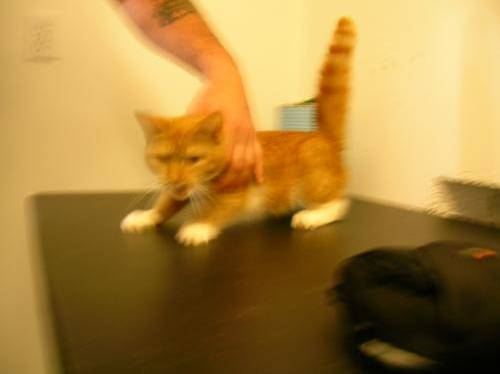

In [15]:
 DISPLAY(ImageIO.read(File(PATH_TO_IMAGE)))

TODO: add cats, dogs wrongly classified

In [16]:
val trainHistory = model.fit(
    trainingDataset = train,
    validationDataset = test,
    trainBatchSize = TRAINING_BATCH_SIZE,
    validationBatchSize = TEST_BATCH_SIZE,
    epochs = EPOCHS
)

val accuracyAfterTraining = model.evaluate(dataset = test, batchSize = TEST_BATCH_SIZE).metrics[Metrics.ACCURACY]

"Accuracy after training $accuracyAfterTraining"

Accuracy after training 0.96875

In [31]:
import org.jetbrains.kotlinx.dl.api.core.history.EpochTrainingEvent

val trainHistoryDF = trainHistory.epochHistory.toDataFrame().explode(EpochTrainingEvent::metricValues, EpochTrainingEvent::valMetricValues)

trainHistoryDF.print()



   epochIndex lossValue metricValues valLossValue valMetricValues
 0          1  0,886016     0,731481     0,366352        0,834821
 1          2  0,050070     0,986111     0,247704        0,968750
 2          3  0,032335     0,986111     0,257207        0,968750
 3          4  0,011453     1,000000     1,010482        0,866071
 4          5  0,231013     0,875000     0,322373        0,968750



In [18]:
%use ggdsl

In [39]:
trainHistoryDF.plot {
    x("epochIndex"<Int>()).axis.breaks(format = "d")
    x.axis.breaks(format = "d")

    line {
        y(
            "metricValues"<Double>().scaled(
                continuousPos(0.0 to 1.0)
            )
        )
        width(3.0)
        color(Color.hex("#6e5596"))
        type(LineType.SOLID)
    }



    line {
        y(
            "valMetricValues"<Double>().scaled(
                continuousPos(0.0 to 1.0)
            )
        )
        width(3.0)
        color(Color.hex("#6e4496"))
        type(LineType.DOTTED)
    }

    layout {
        title = "Accuracy by epochs"
    }
}


Line_56.jupyter.kts (2:28 - 32) Unresolved reference: axis
Line_56.jupyter.kts (3:7 - 11) Unresolved reference: axis

In [175]:
model.save(
    File(PATH_TO_MODEL),
    SavingFormat.JSON_CONFIG_CUSTOM_VARIABLES,
    writingMode = WritingMode.OVERRIDE
)

In [20]:
model.close()

In [177]:
val model2 = Functional.loadModelConfiguration(File("$PATH_TO_MODEL/modelConfig.json"))

val fileDataLoader = pipeline<BufferedImage>()
    .resize {
        outputHeight = IMAGE_SIZE
        outputWidth = IMAGE_SIZE
        interpolation = InterpolationType.BILINEAR
    }
    .convert { colorMode = ColorMode.BGR }
    .toFloatArray { }
    .call(TFModels.CV.ResNet50().preprocessor)
    .fileLoader()

In [178]:
fun setUpModel(it: Functional) {
    it.compile(
        optimizer = RMSProp(),
        loss = Losses.MAE,
        metric = Metrics.ACCURACY
    )
    it.logSummary()

    it.loadWeights(File(PATH_TO_MODEL))
}

In [179]:
model2.use {
    setUpModel(it)
    println("CATS")
    for (i in 0..49) {
        val inputData = fileDataLoader.load(File("../cache/datasets/small-dogs-vs-cats/cat/cat.$i.jpg")).first
        val res = it.predict(inputData)
        println("Predicted object for cat.$i.jpg is $res")
    }

    println("DOGS")

    for (i in 0..49) {
        val inputData = fileDataLoader.load(File("../cache/datasets/small-dogs-vs-cats/dog/dog.$i.jpg")).first
        val res = it.predict(inputData)
        println("Predicted object for dog.$i.jpg is $res")
    }
}

CATS
Predicted object for cat.0.jpg is 0
Predicted object for cat.1.jpg is 0
Predicted object for cat.2.jpg is 0
Predicted object for cat.3.jpg is 0
Predicted object for cat.4.jpg is 0
Predicted object for cat.5.jpg is 0
Predicted object for cat.6.jpg is 0
Predicted object for cat.7.jpg is 0
Predicted object for cat.8.jpg is 0
Predicted object for cat.9.jpg is 0
Predicted object for cat.10.jpg is 0
Predicted object for cat.11.jpg is 0
Predicted object for cat.12.jpg is 0
Predicted object for cat.13.jpg is 0
Predicted object for cat.14.jpg is 0
Predicted object for cat.15.jpg is 0
Predicted object for cat.16.jpg is 0
Predicted object for cat.17.jpg is 0
Predicted object for cat.18.jpg is 0
Predicted object for cat.19.jpg is 0
Predicted object for cat.20.jpg is 0
Predicted object for cat.21.jpg is 0
Predicted object for cat.22.jpg is 0
Predicted object for cat.23.jpg is 0
Predicted object for cat.24.jpg is 0
Predicted object for cat.25.jpg is 0
Predicted object for cat.26.jpg is 0
Predic